In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import opendatasets as od
import matplotlib.image as img
import random
import pathlib 
import os

In [2]:
# Dowload the dataset
dataset_url = 'https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset?datasetId=2049052%3DRice_Image_Dataset&select=Rice_Image_Dataset'
# Look into the data directory
dataset_dir = './rice-image-dataset/Rice_Image_Dataset'
data_dir = pathlib.Path(dataset_dir)
if not os.path.isdir(dataset_dir):
    od.download(dataset_url)

classes = os.listdir(dataset_dir)[1:]
print(classes)

['Jasmine', 'Arborio', 'Karacadag', 'Ipsala', 'Basmati']


Let's check number of files in each classes

In [3]:
images_per_class = []
all_classes = []
for class_name in classes:
    total_images = len(os.listdir(os.path.join(dataset_dir, class_name)))
    images_per_class.append(total_images)
    all_classes.append(class_name)
    print(f'{class_name.capitalize()}: contains {total_images} images')

Jasmine: contains 15000 images
Arborio: contains 15000 images
Karacadag: contains 15000 images
Ipsala: contains 15000 images
Basmati: contains 15000 images


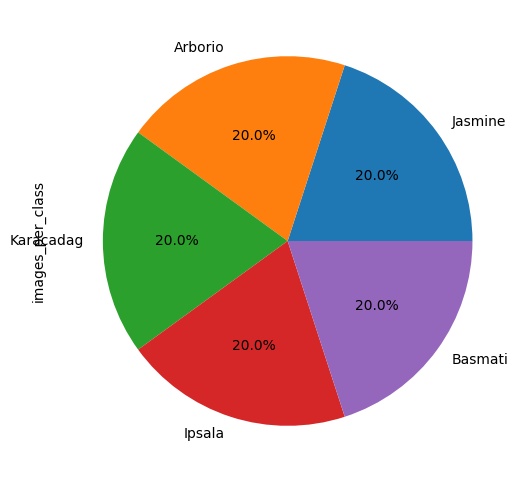

In [4]:
df = pd.DataFrame({'images_per_class': images_per_class, 'all_classes': all_classes}, index=all_classes)
df.plot.pie(y= 'images_per_class', startangle = 0, autopct='%1.1f%%', figsize=(11, 6))
plt.legend('', frameon=False)
plt.show()

Checking the sample images to get better idea about the data

In [5]:
arborio = list(data_dir.glob('Arborio/*'))[:600]
basmati = list(data_dir.glob('Basmati/*'))[:600]
ipsala = list(data_dir.glob('Ipsala/*'))[:600]
jasmine = list(data_dir.glob('Jasmine/*'))[:600]
karacadag = list(data_dir.glob('Karacadag/*'))[:600]

In [6]:
rand_idx = random.randint(0, 600)
rand_idx

43

In [7]:
classes

['Jasmine', 'Arborio', 'Karacadag', 'Ipsala', 'Basmati']

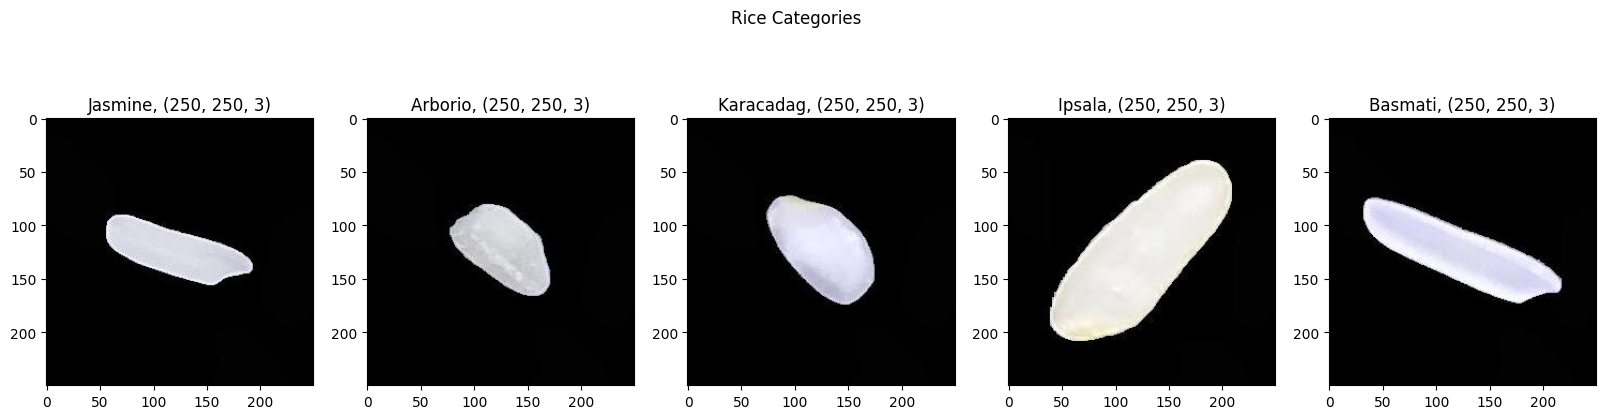

In [8]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Categories')

jasmine_image = img.imread(jasmine[rand_idx])
arborio_image = img.imread(arborio[rand_idx])
karacadag_image = img.imread(karacadag[rand_idx])
ipsala_image = img.imread(ipsala[rand_idx])
basmati_image = img.imread(basmati[rand_idx])

classes_img = [jasmine_image, arborio_image, karacadag_image, ipsala_image, basmati_image]
for i, (class_name, image) in enumerate(zip(classes, classes_img)):
    ax[i].set_title(f'{class_name}, {image.shape}')
    ax[i].imshow(image)
plt.show()


###  Loading the data into the memory



In [9]:
BATCH_SIZE = 128
IMG_HEIGHT = 200
IMG_WIDTH = 200
INPUT_SHAPE  = (IMG_HEIGHT, IMG_WIDTH, 3)

In [10]:
train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  shuffle=True,
  label_mode='categorical' ,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 75000 files belonging to 5 classes.
Using 60000 files for training.


In [11]:
val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical' ,
  shuffle=True,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  seed=42,
  batch_size=BATCH_SIZE,)

Found 75000 files belonging to 5 classes.
Using 15000 files for validation.


Standardizing the data

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
import numpy as np

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
img_batch, labels_batch = next(iter(normalized_ds))

first_image = img_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


##  CNN Model

In [16]:
cnn_model = keras.Sequential([
    layers.Conv2D(filters=32,kernel_size= (3,3), activation='relu', input_shape=INPUT_SHAPE),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32,kernel_size= (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(filters=64,kernel_size= (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64,kernel_size= (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(filters=128,kernel_size= (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=128,kernel_size= (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax'),
    ])


In [17]:
optimizer = tf.keras.optimizers.Adam()
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 196, 196, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 32)       0         
 )                                                               
                                                        

In [18]:
model_dir = 'saved_models'
model_dir = pathlib.Path(model_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [19]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=model_dir/'cnn_model.hdf5',
    monitor='val_accuracy', 
    mode='max', 
    verbose=1, 
    save_best_only=True)

In [20]:

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)


In [21]:
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, 
    patience=5, 
    min_lr=1e-3)

callbacks=[early_stopping_cb, reduce_lr_cb, checkpoint_cb]

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)

cnn_history = cnn_model.fit(
    train_ds,
    epochs= 100,
    validation_data = val_ds,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks]
)

Epoch 1/100
469/469 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9753
Epoch 1: val_accuracy improved from -inf to 0.98827, saving model to saved_models/cnn_model.hdf5
469/469 [==============================] - 125s 253ms/step - loss: 0.0763 - accuracy: 0.9753 - val_loss: 0.0338 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9905
Epoch 2: val_accuracy did not improve from 0.98827
469/469 [==============================] - 117s 249ms/step - loss: 0.0295 - accuracy: 0.9905 - val_loss: 8.7895 - val_accuracy: 0.2001 - lr: 0.0010
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9923
Epoch 3: val_accuracy did not improve from 0.98827
469/469 [==============================] - 117s 248ms/step - loss: 0.0241 - accuracy: 0.9923 - val_loss: 0.2073 - val_accuracy: 0.9323 - lr: 0.0010
Epoch 4/100
469/469 [==============================] - ETA: 0s - l

In [23]:
cnn_model.evaluate(val_ds)

118/118 [==============================] - 6s 48ms/step - loss: 0.0338 - accuracy: 0.9883


[0.03375685587525368, 0.98826664686203]

In [24]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

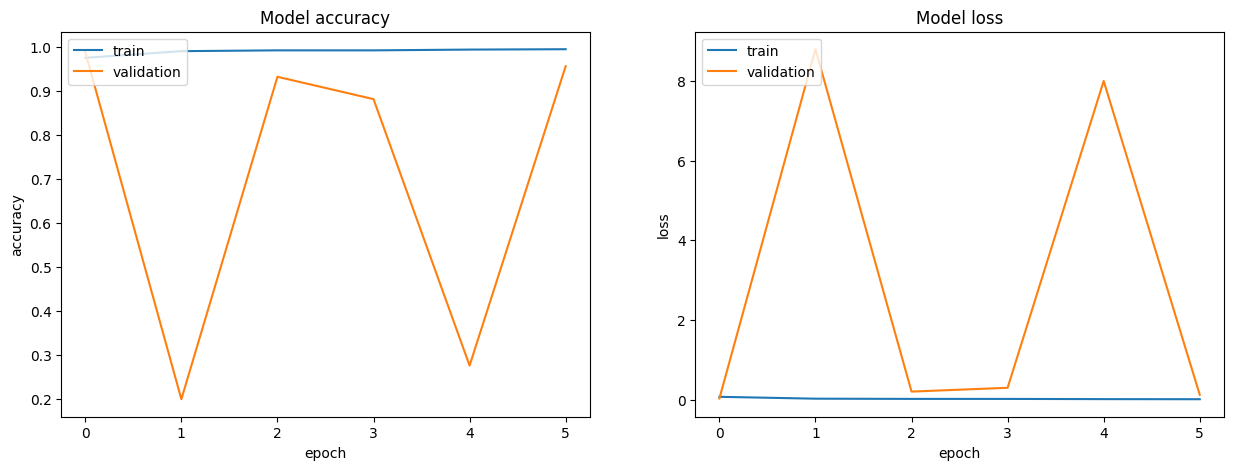

In [25]:
plot_train_history(cnn_history)

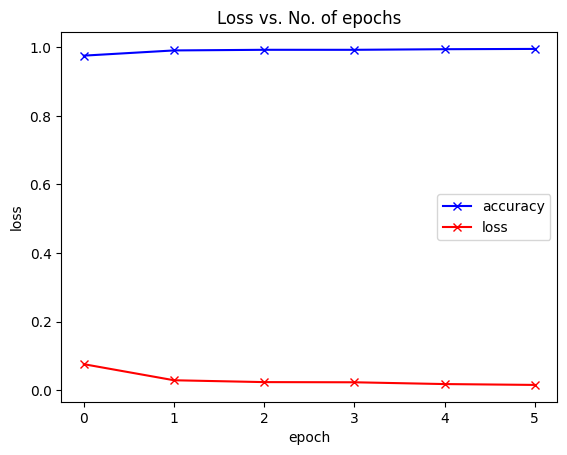

In [26]:
loss = cnn_history.history['loss']
accuracy = cnn_history.history['accuracy']
plt.plot(accuracy, '-bx')
plt.plot(loss, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend([ 'accuracy','loss'])
plt.title('Loss vs. No. of epochs')
plt.show()

##  Model Evaluation 

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
y_preds = cnn_model.predict(val_ds)

118/118 [==============================] - 5s 45ms/step


In [46]:
val_ds_labels = np.concatenate([y for x, y in val_ds], axis=0)

In [47]:
val_ds_labels.shape

(15000, 5)

In [44]:
y_preds = np.argmax(y_preds, axis=1)
y_preds.shape

(15000,)

In [51]:
preds = np.array([])
labels = np.array([])

for x, y in val_ds:
    preds = np.concatenate([preds,  np.argmax(cnn_model.predict(x), axis=1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=labels, predictions=preds)

1/1 [==============================] - 0s 89ms/step


<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[2979,    0,    0,    7,   43],
       [   0, 3095,    0,   20,    1],
       [   8,    0, 2890,    0,    0],
       [  20,   61,    2, 2907,    4],
       [  10,    0,    0,    0, 2953]], dtype=int32)>

In [52]:
report1 = classification_report(labels, preds, target_names=classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Jasmine,0.987405,0.983493,0.985445,3029.000000
Arborio,0.980672,0.993261,0.986926,3116.000000
Karacadag,0.999308,0.997239,0.998273,2898.000000
Ipsala,0.990798,0.970942,0.980769,2994.000000
Basmati,0.984005,0.996625,0.990275,2963.000000
accuracy,0.988267,0.988267,0.988267,0.988267
macro avg,0.988438,0.988312,0.988338,15000.000000
weighted avg,0.988312,0.988267,0.988252,15000.000000
